In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/jpx-tokyo-stock-exchange-prediction/stock_list.csv
/kaggle/input/jpx-tokyo-stock-exchange-prediction/example_test_files/sample_submission.csv
/kaggle/input/jpx-tokyo-stock-exchange-prediction/example_test_files/options.csv
/kaggle/input/jpx-tokyo-stock-exchange-prediction/example_test_files/financials.csv
/kaggle/input/jpx-tokyo-stock-exchange-prediction/example_test_files/secondary_stock_prices.csv
/kaggle/input/jpx-tokyo-stock-exchange-prediction/example_test_files/trades.csv
/kaggle/input/jpx-tokyo-stock-exchange-prediction/example_test_files/stock_prices.csv
/kaggle/input/jpx-tokyo-stock-exchange-prediction/jpx_tokyo_market_prediction/competition.cpython-37m-x86_64-linux-gnu.so
/kaggle/input/jpx-tokyo-stock-exchange-prediction/jpx_tokyo_market_prediction/__init__.py
/kaggle/input/jpx-tokyo-stock-exchange-prediction/data_specifications/stock_fin_spec.csv
/kaggle/input/jpx-tokyo-stock-exchange-prediction/data_specifications/trades_spec.csv
/kaggle/input/jpx-tokyo-stock-

In [2]:
import sys
import warnings
from tqdm import tqdm
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',None) 

In [3]:
stock_prices = pd.read_csv('/kaggle/input/jpx-tokyo-stock-exchange-prediction/train_files/stock_prices.csv')
#secondary_stock_prices = pd.read_csv("/kaggle/input/jpx-tokyo-stock-exchange-prediction/train_files/secondary_stock_prices.csv")
#supplemental_prices = pd.read_csv("/kaggle/input/jpx-tokyo-stock-exchange-prediction/supplemental_files/stock_prices.csv")
#supplemental_secondary_stock_prices = pd.read_csv("/kaggle/input/jpx-tokyo-stock-exchange-prediction/supplemental_files/secondary_stock_prices.csv")
stock_list = pd.read_csv("/kaggle/input/jpx-tokyo-stock-exchange-prediction/stock_list.csv")
financials = pd.read_csv("/kaggle/input/jpx-tokyo-stock-exchange-prediction/train_files/financials.csv")

In [4]:
#supplemental_prices["Date"] = pd.to_datetime(supplemental_prices["Date"])
#supplemental_secondary_stock_prices["Date"] = pd.to_datetime(supplemental_secondary_stock_prices["Date"])
#supplemental_prices["Date"] = supplemental_prices["Date"].dt.strftime("%Y-%m-%d")
#supplemental_secondary_stock_prices["Date"] = supplemental_secondary_stock_prices["Date"].dt.strftime("%Y-%m-%d")

In [5]:
#stock_prices = pd.concat([stock_prices,secondary_stock_prices], axis=0)
#stock_prices = pd.concat([stock_prices,supplemental_prices], axis=0)
#stock_prices = pd.concat([stock_prices,supplemental_secondary_stock_prices], axis=0)
#del secondary_stock_prices
#del supplemental_prices
#del supplemental_secondary_stock_prices

# Preprocessing

In [6]:
def prices_preprocessing(df):
    df.drop(df[df["SecuritiesCode"].isnull()].index,inplace =True)
    df.drop(df[df["Target"].isnull()].index,inplace = True)
    df.drop(["RowId"],axis=1)
    df = df.sort_values(by = ["SecuritiesCode", "Date"])
    return df

def financials_preprocessing(df):
    df.drop(df[df['SecuritiesCode'].isnull()].index, inplace=True)
    
    fin_features=['Date','SecuritiesCode','NetSales','OperatingProfit','OrdinaryProfit','Profit','EarningsPerShare','TotalAssets','Equity',
    'EquityToAssetRatio','BookValuePerShare','ResultDividendPerShareAnnual','ForecastDividendPerShareAnnual','ForecastNetSales','ForecastOperatingProfit',
    'ForecastOrdinaryProfit','ForecastProfit','ForecastEarningsPerShare','ApplyingOfSpecificAccountingOfTheQuarterlyFinancialStatements',
    'MaterialChangesInSubsidiaries','ChangesBasedOnRevisionsOfAccountingStandard','NumberOfIssuedAndOutstandingSharesAtTheEndOfFiscalYearIncludingTreasuryStock',
    'NumberOfTreasuryStockAtTheEndOfFiscalYear','AverageNumberOfShares']
    
    df=df[fin_features]
    
    return df

def fill_null_fin(df):
    df.sort_values(by=['SecuritiesCode','Date'],axis=0,ascending=True,inplace=True)
    
    df.replace('－', np.nan, inplace=True)

    fill_features=['NetSales','OperatingProfit','OrdinaryProfit','Profit','EarningsPerShare','TotalAssets','Equity',
    'EquityToAssetRatio','BookValuePerShare','ResultDividendPerShareAnnual','ForecastDividendPerShareAnnual','ForecastNetSales','ForecastOperatingProfit',
    'ForecastOrdinaryProfit','ForecastProfit','ForecastEarningsPerShare','ApplyingOfSpecificAccountingOfTheQuarterlyFinancialStatements',
    'MaterialChangesInSubsidiaries','ChangesBasedOnRevisionsOfAccountingStandard','NumberOfIssuedAndOutstandingSharesAtTheEndOfFiscalYearIncludingTreasuryStock',
    'NumberOfTreasuryStockAtTheEndOfFiscalYear','AverageNumberOfShares']

    to_float=['NetSales','OperatingProfit','OrdinaryProfit','Profit','EarningsPerShare','TotalAssets','Equity',
    'EquityToAssetRatio','BookValuePerShare','ResultDividendPerShareAnnual','ForecastDividendPerShareAnnual','ForecastNetSales','ForecastOperatingProfit',
    'ForecastOrdinaryProfit','ForecastProfit','ForecastEarningsPerShare']
    to_int=['SecuritiesCode','NumberOfIssuedAndOutstandingSharesAtTheEndOfFiscalYearIncludingTreasuryStock','NumberOfTreasuryStockAtTheEndOfFiscalYear','AverageNumberOfShares']

    for i in fill_features:
        df[i].fillna(method='bfill',inplace=True)
        df[i].fillna(method='ffill',inplace=True)
   
    df[to_int]= df[to_int].astype("int64")
    df[to_float]=df[to_float].astype("float64")
    return df

from sklearn.preprocessing import OrdinalEncoder
def stock_list_preprocessing(df):
    cat_features=['SecuritiesCode','NewMarketSegment','Section/Products', '33SectorCode','17SectorCode','NewIndexSeriesSizeCode','Universe0']
    df['NewMarketSegment']=df['NewMarketSegment'].fillna('other')
    #temp = df["SecuritiesCode"]
    df=df[cat_features]   
    encoder = OrdinalEncoder()
    df[cat_features] = encoder.fit_transform(df[cat_features])
    df[cat_features]=df[cat_features].astype(int)
    #df = temp + df
    return df

from sklearn.preprocessing import OneHotEncoder
def stock_list_xgb_preprocessing(df):
    cat_features=['SecuritiesCode','NewMarketSegment','Section/Products', '33SectorCode','17SectorCode','NewIndexSeriesSizeCode','Universe0']
    df['NewMarketSegment']=df['NewMarketSegment'].fillna('other')
    df = df.copy()
    #temp = df["SecuritiesCode"]
    df=df[cat_features]   
    encoder = OneHotEncoder()
    df[cat_features] = encoder.fit_transform(df[cat_features])
    df[cat_features]=df[cat_features].astype(int)
    #df = temp + df
    return df

In [7]:
cat_features=['Section/Products', '33SectorCode','17SectorCode','NewIndexSeriesSizeCode','NewMarketSegment']
stock_prices = prices_preprocessing(stock_prices)
financials = financials_preprocessing(financials)
#financials = fill_null_fin(financials)
stock_list_lgbm = stock_list_preprocessing(stock_list)
#stock_list_xgb = stock_list_xgb_preprocessing(stock_list)

In [8]:
stock_prices = pd.merge(stock_prices,stock_list_lgbm,on="SecuritiesCode",how="left")
stock_prices = pd.merge(stock_prices,financials,on=["SecuritiesCode",'Date'],how="left")
del stock_list,financials
stock_prices = fill_null_fin(stock_prices)
stock_prices.SecuritiesCode.nunique()

2000

In [9]:
#stock_prices_test = stock_prices[stock_prices.Date>="2020-10-30"]
#stock_prices = stock_prices[stock_prices.Date<"2020-10-30"]
stock_prices.drop(["RowId"],axis=1,inplace = True)

In [10]:
stock_prices.drop(["AdjustmentFactor", "ExpectedDividend","SupervisionFlag"],axis=1,inplace = True)

In [11]:
stock_prices.head()

,Date,SecuritiesCode,Open,High,Low,Close,Volume,Target,NewMarketSegment,Section/Products,33SectorCode,17SectorCode,NewIndexSeriesSizeCode,Universe0,NetSales,OperatingProfit,OrdinaryProfit,Profit,EarningsPerShare,TotalAssets,Equity,EquityToAssetRatio,BookValuePerShare,ResultDividendPerShareAnnual,ForecastDividendPerShareAnnual,ForecastNetSales,ForecastOperatingProfit,ForecastOrdinaryProfit,ForecastProfit,ForecastEarningsPerShare,ApplyingOfSpecificAccountingOfTheQuarterlyFinancialStatements,MaterialChangesInSubsidiaries,ChangesBasedOnRevisionsOfAccountingStandard,NumberOfIssuedAndOutstandingSharesAtTheEndOfFiscalYearIncludingTreasuryStock,NumberOfTreasuryStockAtTheEndOfFiscalYear,AverageNumberOfShares
0,2017-01-04,1301,2734.0,2755.0,2730.0,2742.0,31400,0.000730,4.0,9.0,25.0,2.0,0.0,0.0,1.799750e+11,2.872000e+09,2.827000e+09,2.449000e+09,233.26,1.171680e+11,2.577900e+10,0.217,2378.09,60.0,50.0,2.440000e+11,3.500000e+09,3.300000e+09,2.100000e+09,199.94,False,False,True,10928283,425455,10503022
1,2017-01-05,1301,2743.0,2747.0,2735.0,2738.0,17900,0.002920,4.0,9.0,25.0,2.0,0.0,0.0,1.799750e+11,2.872000e+09,2.827000e+09,2.449000e+09,233.26,1.171680e+11,2.577900e+10,0.217,2378.09,60.0,50.0,2.440000e+11,3.500000e+09,3.300000e+09,2.100000e+09,199.94,False,False,True,10928283,425455,10503022
2,2017-01-06,1301,2734.0,2744.0,2720.0,2740.0,19900,-0.001092,4.0,9.0,25.0,2.0,0.0,0.0,1.799750e+11,2.872000e+09,2.827000e+09,2.449000e+09,233.26,1.171680e+11,2.577900e+10,0.217,2378.09,60.0,50.0,2.440000e+11,3.500000e+09,3.300000e+09,2.100000e+09,199.94,False,False,True,10928283,425455,10503022
3,2017-01-10,1301,2745.0,2754.0,2735.0,2748.0,24200,-0.005100,4.0,9.0,25.0,2.0,0.0,0.0,1.799750e+11,2.872000e+09,2.827000e+09,2.449000e+09,233.26,1.171680e+11,2.577900e+10,0.217,2378.09,60.0,50.0,2.440000e+11,3.500000e+09,3.300000e+09,2.100000e+09,199.94,False,False,True,10928283,425455,10503022
4,2017-01-11,1301,2748.0,2752.0,2737.0,2745.0,9300,-0.003295,4.0,9.0,25.0,2.0,0.0,0.0,1.799750e+11,2.872000e+09,2.827000e+09,2.449000e+09,233.26,1.171680e+11,2.577900e+10,0.217,2378.09,60.0,50.0,2.440000e+11,3.500000e+09,3.300000e+09,2.100000e+09,199.94,False,False,True,10928283,425455,10503022


# Feature Extraction and Data Cleaning

In [12]:
##Calculating Indicators

#def adj_close(df):                      ##in case of bonus stock decleared adjustment factor can be greater than 1 
#    df = df.sort_values("Date", ascending = True)
#   df["AdjustedClose"] = (df["AdjustmentFactor"]*df["Close"])
#    df["AdjustedOpen"]  = (df["AdjustmentFactor"]*df["Open"])
#    df["AdjustedLow"] = (df["AdjustmentFactor"]*df["Low"])
#    df["AdjustedHigh"] = (df["AdjustmentFactor"]*df["High"])
    
#    df.drop("Open",axis=1,inplace=True)
#   df.drop("Close",axis=1,inplace=True)
#    df.drop("High",axis=1,inplace=True)
#   df.drop("Low",axis=1,inplace=True)
#    df.drop("AdjustmentFactor",axis=1,inplace=True)
#    return df

#def adjusting_price(df):
#    df = df.copy()
#    df["Date"] = pd.to_datetime(df["Date"], format = "%Y-%m-%d")
#    df = df.sort_values(["SecuritiesCode","Date"])
#    df = df.groupby("SecuritiesCode").apply(adj_close).reset_index(drop=True)
#   return df

def bias(frame, window):
    return (frame - frame.rolling(window).mean())/frame.rolling(window).mean()

def rsi(close,window):
    diff = close.diff()
    diff = diff.iloc[1:]
    up = diff.where(diff>0,0)
    down = -diff.where(diff<0,0)
    ma_up = up.rolling(window).mean()
    ma_down = down.rolling(window).mean()
    rs = ma_up/ma_down
    rsi = 100 - (100/(1+rs))
    return rsi

def atr(high, low, close, window):
    tr  = high.combine(low, min).combine(close.shift(), max) - low.combine(close.shift(), min).combine(high.shift(), max)
    atr = tr.rolling(window).mean()
    return atr

def cmo(close,window):
    diff = close.diff()
    diff = diff.iloc[1:]
    ma1 = diff.where(diff > 0, 0).rolling(window).sum()
    ma2 = (-diff.where(diff < 0, 0)).rolling(window).sum()
    cmo = (ma1 - ma2) / (ma1 + ma2) * 100
    return cmo

def ADX(high, low, close, window):
    tr  = high.combine(low, min).combine(close.shift(), max) - low.combine(close.shift(), min).combine(high.shift(), max)
    
    pos_DM = high - high.shift()
    neg_DM = low.shift() - low
    pos_DM[pos_DM < neg_DM] = 0
    neg_DM[neg_DM < pos_DM] = 0
        
    ATR = atr(high, low, close, window)
    
    pos_DI = (pos_DM/ATR)*100
    neg_DI = (neg_DM/ATR)*100
    
    DX = abs((pos_DI-neg_DI)/(pos_DI+neg_DI))*100
    
    ADX = DX.rolling(window).mean()
    return ADX

def amv(close, volume, window):
    amv = ((close - close.shift(1)) / close.shift(1) * volume).rolling(window).sum()
    return amv

def compute_boll(close, window, k):
    mid = close.rolling(window).mean()
    std = close.rolling(window).std()
    upper = mid + k * std
    lower = mid - k * std
    return pd.DataFrame({'boll_upper': upper, 'boll_mid': mid, 'boll_lower': lower})

def volatility(df):
    return df.groupby("SecuritiesCode")["Close"].apply(lambda x: x.rolling(window = 50).std()/x.rolling(window=50).mean()).reset_index(level = 0, drop=True)

def feature_ext(df):
    
    df["Volatility"] = volatility(df).bfill()
    
    df["std_5"] = df.groupby("SecuritiesCode")["Close"].apply(lambda x: x.rolling(window = 5).std()).reset_index(drop = True).bfill()
    df["std_10"] = df.groupby("SecuritiesCode")["Close"].apply(lambda x: x.rolling(window = 10).std()).reset_index(drop = True).bfill()
    df["std_20"] = df.groupby("SecuritiesCode")["Close"].apply(lambda x: x.rolling(window = 20).std()).reset_index(drop = True).bfill()
    
    df['returns'] = df.groupby("SecuritiesCode")['Close'].apply(lambda x: np.log(x / x.shift(1))).bfill()
    
    df["sma_5"] = (df.groupby("SecuritiesCode")['Close'].rolling(window=5).mean()).reset_index(drop=True).bfill()
    df['sma10'] = (df.groupby("SecuritiesCode")['Close'].rolling(window=10).mean()).reset_index(drop=True).bfill()
    df['sma20'] = (df.groupby("SecuritiesCode")['Close'].rolling(window=20).mean()).reset_index(drop=True).bfill()
    df['sma30'] = (df.groupby("SecuritiesCode")['Close'].rolling(window=30).mean()).reset_index(drop=True).bfill()

    df["ema_5"] = (df.groupby("SecuritiesCode")["Close"].ewm(span = 5,adjust = False).mean()).reset_index(drop=True).bfill()
    df["ema_10"] = (df.groupby("SecuritiesCode")["Close"].ewm(span = 10,adjust = False).mean()).reset_index(drop=True).bfill()
    df["ema_20"] = (df.groupby("SecuritiesCode")["Close"].ewm(span = 20,adjust = False).mean()).reset_index(drop=True).bfill()
    df["ema_30"] = (df.groupby("SecuritiesCode")["Close"].ewm(span = 30,adjust = False).mean()).reset_index(drop=True).bfill()
    
    df["atr_14"] = df.groupby("SecuritiesCode").apply(lambda x: atr(x["High"],x["Low"],x["Close"],window = 14)).reset_index(drop = True).bfill()
    
    df["bias_5"] = df.groupby("SecuritiesCode").apply(lambda x: bias(x["Close"],window = 5)).reset_index(drop = True).bfill()
    
    #df["atr_14"] = df.groupby("SecuritiesCode").apply(lambda x: (x["AdjustedHigh"],x["AdjustedLow"],x["AdjustedClose"],window = 14)).reset_index(drop = True).bfill()
    
    df["amv_7"] = df.groupby("SecuritiesCode").apply(lambda x: amv(x["Close"],x["Volume"],window = 7)).reset_index(drop = True).bfill()
    
    df["rsi_14"] = df.groupby("SecuritiesCode").apply(lambda x: rsi(x["Close"],window = 14)).reset_index(drop = True).bfill()
    
    boll_df = df.groupby('SecuritiesCode')['Close'].apply(lambda x: compute_boll(x, 20, 2)).reset_index(drop=True).bfill()
    df = df.join(boll_df[['boll_upper','boll_mid','boll_lower']])
    
    df["ADX_14"] = df.groupby("SecuritiesCode").apply(lambda x: ADX(x["High"],x["Low"],x["Close"],window = 14)).reset_index(drop=True).bfill()
    
    df["cmo_14"] = df.groupby("SecuritiesCode").apply(lambda x: cmo(x["Close"],window = 14)).reset_index(drop=True).bfill()
    
    df["ROC_1"] = df.groupby("SecuritiesCode")['Close'].pct_change(periods=1).bfill() 
    df["ROC_5"] = df.groupby("SecuritiesCode")['Close'].pct_change(periods=5).bfill() 
    df["ROC_10"] = df.groupby("SecuritiesCode")['Close'].pct_change(periods=10).bfill() 
    df["ROC_20"] = df.groupby("SecuritiesCode")['Close'].pct_change(periods=20).bfill() 
    df["ROC_30"] = df.groupby("SecuritiesCode")['Close'].pct_change(periods=30).bfill() 
    df["optimum_ROC"] = (df["ROC_1"] + df["ROC_5"] + df["ROC_10"] + df["ROC_20"] + df["ROC_30"])/5
    
    return df

def clean(df):
    df["date"] = pd.to_datetime(df['Date'],format='%Y-%m-%d')
    df = df.sort_values(by = "Date",axis = 0, ascending = True,inplace = False)
    #df["ExpectedDividend"] = df["ExpectedDividend"].mask(df["ExpectedDividend"]>0,1)
    #df = adjusting_price(df)
    
    df['Close'].fillna(method='ffill', inplace=True)
    df['Close'].fillna(method='bfill', inplace=True)
    df['Open'].fillna(method='ffill', inplace=True)
    df['Open'].fillna(method='bfill', inplace=True)
    df['High'].fillna(method='ffill', inplace=True)
    df['High'].fillna(method='bfill', inplace=True)
    df['Low'].fillna(method='ffill', inplace=True)
    df['Low'].fillna(method='bfill', inplace=True)
    return df



def compute_spread_per_day(df,portfolio_size=200,top_rank_weight_ratio=2):
    assert df["Rank"].min() == 0
    assert df["Rank"].max() == len(df["Rank"])-1
    weights = np.linspace(start = top_rank_weight_ratio, stop=1, num = portfolio_size)
    purchase = (df.sort_values(by="Rank")["Target"][:portfolio_size]*weights).sum()/weights.mean()
    short = (df.sort_values(by="Rank",ascending = False)["Target"][:portfolio_size]*weights).sum()/weights.mean()
    return purchase-short

def spread_return_sharpe(df,portfolio_size =200,top_rank_weight_ratio = 2.0):
    buf = df.groupby("Date").apply(compute_spread_per_day)
    sharpe_ratio = buf.mean()/buf.std()
    return sharpe_ratio

In [13]:
temp = stock_prices.groupby("SecuritiesCode").apply(clean).reset_index(drop=True)
stock_final = feature_ext(temp)
del temp
del stock_prices
import gc
gc.collect()

52

In [14]:
stock_final.drop('date',axis=1,inplace=True)
stock_final["Date"] = pd.to_datetime(stock_final["Date"])
stock_final.sort_values(["Date", "SecuritiesCode"],inplace = True)

# Model Building and Training

In [15]:
import lightgbm as lgb
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=10,gap = 3000)

X = stock_final.drop(["Target"],axis=1)
y = stock_final["Target"].to_numpy()

sharpe_ratio = []

for train_index, val_index in tscv.split(X):
    X_train, X_val = X.iloc[train_index,:], X.iloc[val_index,:]
    y_train, y_val = y[train_index], y[val_index]
    
    dtrain = lgb.Dataset(X_train.drop(["Date"],axis=1), label = y_train)
    dvalid = lgb.Dataset(X_val.drop(["Date"],axis=1), label = y_val)
    
    params = {
        'learning_rate': 0.005,
        'objective': 'regression_l1',
        'boosting': 'gbdt',
        'random_state': 5,
        'verbosity': 1,
        'metric': 'mae',
        'feature_fraction': 0.4,
        'bagging_fraction': 0.35,
        'n_jobs': -1,
        'force_col_wise':True
     }
    
    model = lgb.train(params = params, train_set = dtrain, valid_sets = [dtrain,dvalid],early_stopping_rounds = 25 )
    
    y_pred = model.predict(X_train.drop(["Date"],axis=1))
    rank = []
    val_dates = X_train.Date.unique()[1:-1]
    X_val_df = X_train[X_train.Date.isin(val_dates)]
    
    for i in X_val_df.Date.unique():
        temp_df = X_val_df[X_val_df.Date==i]
        temp_df["pred"] = model.predict(temp_df.drop(["Date"],axis=1))
        temp_df["Rank"] = (temp_df["pred"].rank(method="first", ascending=False)-1).astype(int)
        rank.append(temp_df["Rank"].values)
        
    stock_rank=pd.Series([x for y in rank for x in y], name="Rank")
    
    sharpe_df=pd.concat([X_val_df.reset_index(drop=True),stock_rank,stock_final[stock_final.Date.isin(val_dates)]['Target'].reset_index(drop=True)], axis=1)
    sharpe=spread_return_sharpe(sharpe_df)
    sharpe_ratio.append(sharpe)
    gc.collect()
    
print("Mean : {:.4f}, and Standard Dev : {:.4f}".format(np.mean(sharpe_ratio),np.std(sharpe_ratio)))
    

[LightGBM] [Info] Total Bins 13303
[LightGBM] [Info] Number of data points in the train set: 209313, number of used features: 62
[1]	training's l1: 0.0120678	valid_1's l1: 0.0120585
Training until validation scores don't improve for 25 rounds
[2]	training's l1: 0.0120675	valid_1's l1: 0.0120585
[3]	training's l1: 0.0120673	valid_1's l1: 0.0120586
[4]	training's l1: 0.012067	valid_1's l1: 0.0120586
[5]	training's l1: 0.0120668	valid_1's l1: 0.0120586
[6]	training's l1: 0.0120666	valid_1's l1: 0.0120586
[7]	training's l1: 0.0120665	valid_1's l1: 0.0120586
[8]	training's l1: 0.0120662	valid_1's l1: 0.0120586
[9]	training's l1: 0.0120661	valid_1's l1: 0.0120586
[10]	training's l1: 0.0120658	valid_1's l1: 0.0120586
[11]	training's l1: 0.0120657	valid_1's l1: 0.0120586
[12]	training's l1: 0.0120653	valid_1's l1: 0.0120586
[13]	training's l1: 0.012065	valid_1's l1: 0.0120586
[14]	training's l1: 0.0120648	valid_1's l1: 0.0120586
[15]	training's l1: 0.0120645	valid_1's l1: 0.0120586
[16]	traini

In [16]:
X_train = stock_final.drop(["Target"],axis=1)
y_train = stock_final["Target"]
from lightgbm import LGBMRegressor
model = LGBMRegressor(**params).fit(X_train.drop(["Date"],axis=1),y_train)

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.35, subsample=1.0 will be ignored. Current value: bagging_fraction=0.35
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.35, subsample=1.0 will be ignored. Current value: bagging_fraction=0.35
[LightGBM] [Info] Total Bins 13300
[LightGBM] [Info] Number of data points in the train set: 2335363, number of used features: 62


**Train Set Results**

In [17]:
s = pd.concat([sharpe_df["Date"],sharpe_df["SecuritiesCode"],sharpe_df["Rank"]],axis=1)
s = s.sort_values(["Date","Rank"])
s.head()

,Date,SecuritiesCode,Rank
781,2017-01-05,5273,0
880,2017-01-05,6055,1
1229,2017-01-05,7261,2
1042,2017-01-05,6538,3
1094,2017-01-05,6755,4


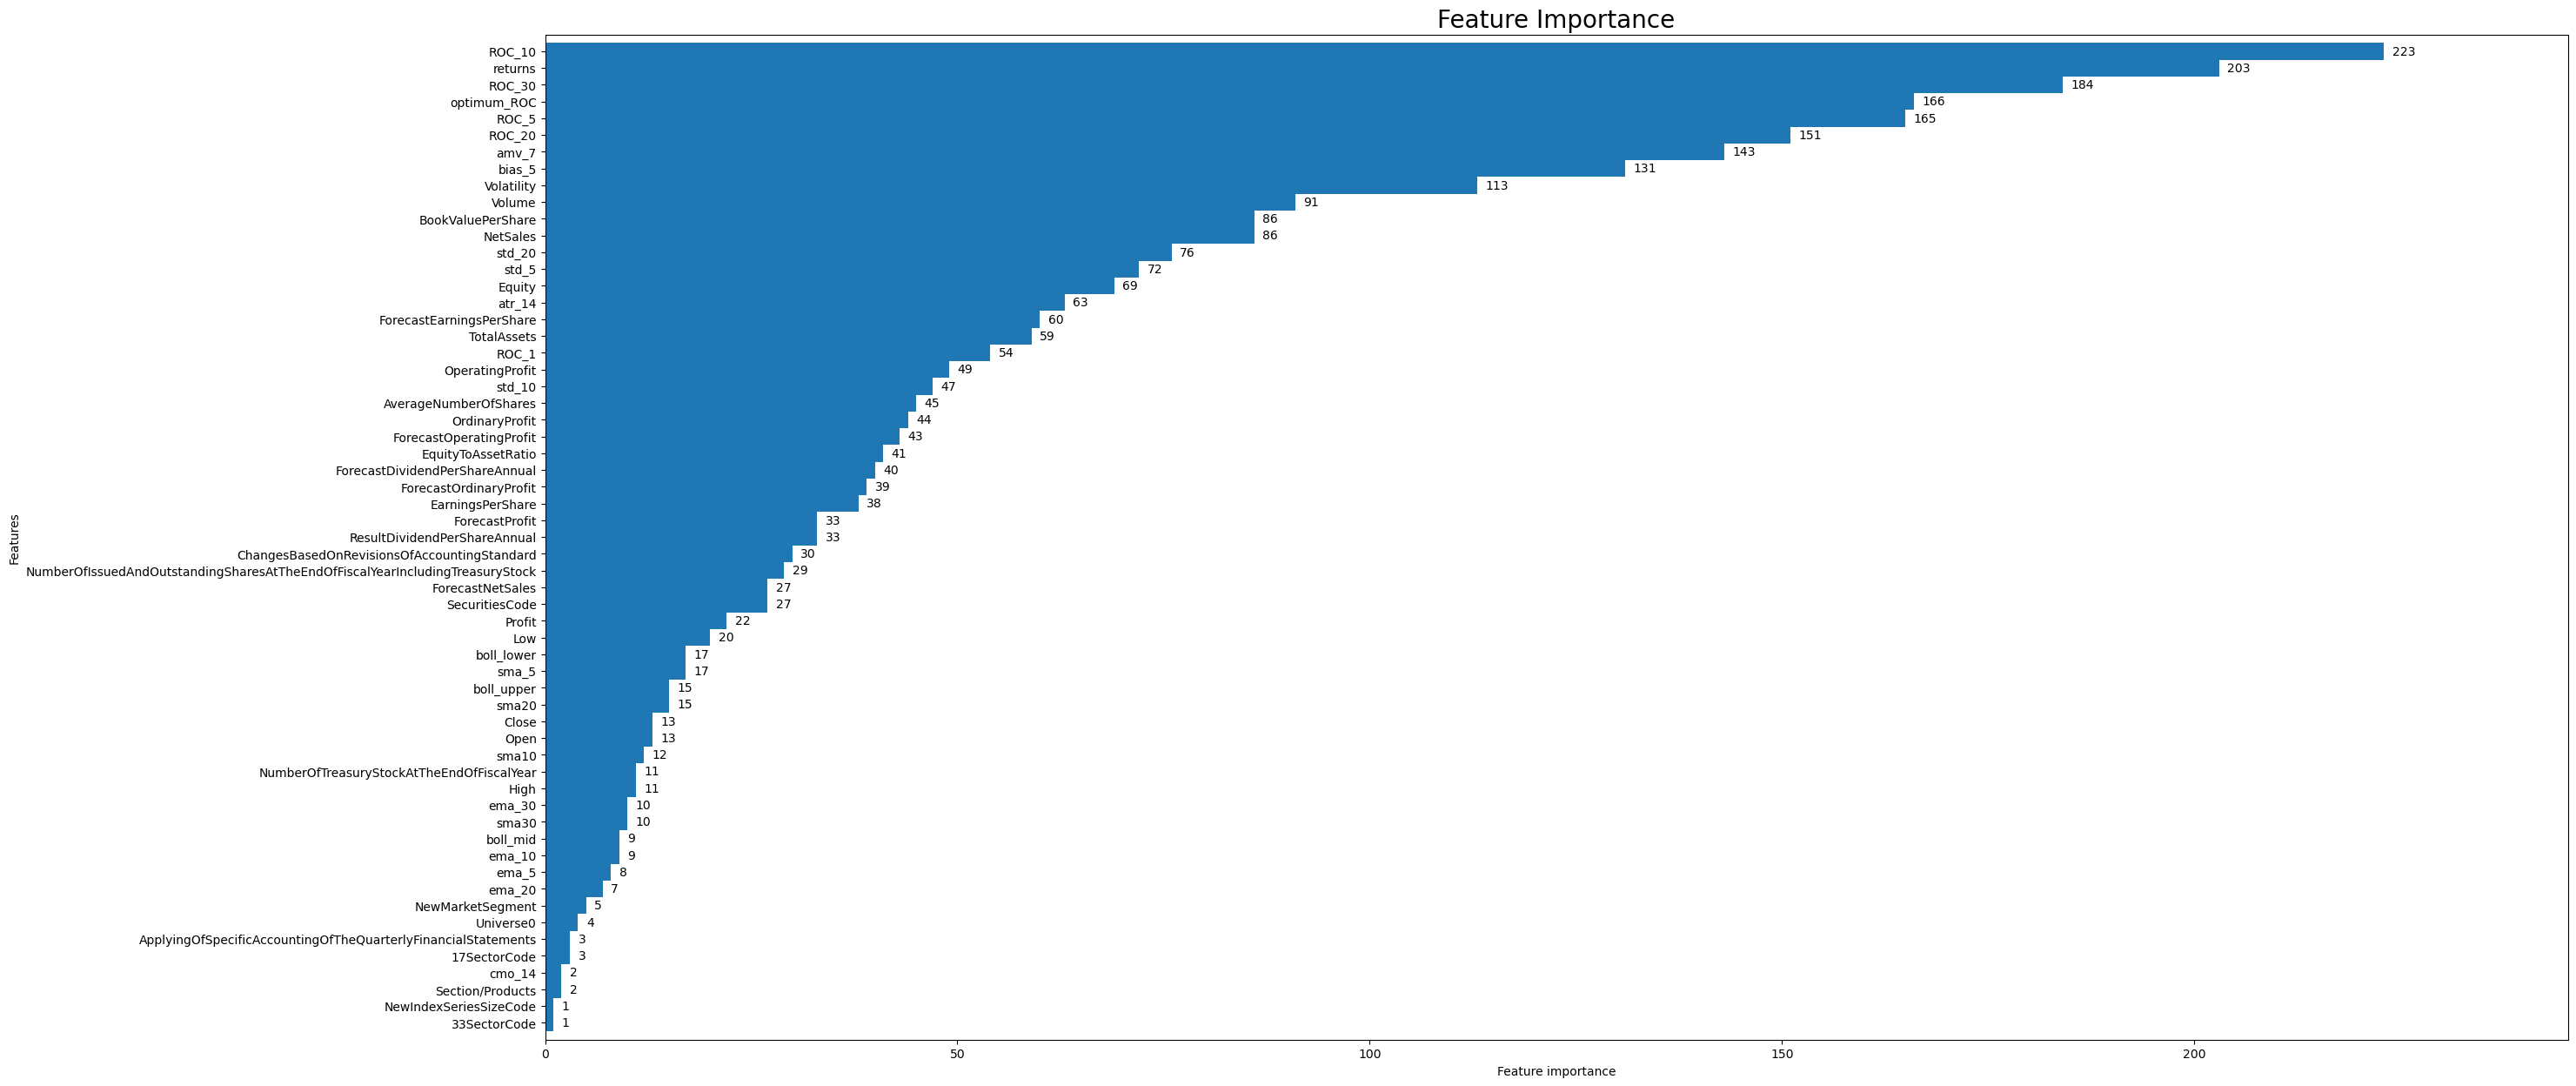

In [18]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(30,15))
lgb.plot_importance(model, height=1, ax=ax)
ax.grid(False)
plt.title("Feature Importance", fontsize=20)
plt.show()

# Submission

In [19]:
import jpx_tokyo_market_prediction
env = jpx_tokyo_market_prediction.make_env()  
iter_test = env.iter_test()
sample_submission = pd.read_csv("/kaggle/input/jpx-tokyo-stock-exchange-prediction/example_test_files/sample_submission.csv")
features = ['Date','SecuritiesCode','Open','High','Low','Close','Volume','AdjustmentFactor','ExpectedDividend','SupervisionFlag']
counter = 0
for (prices, options, financials, trades, secondary_prices, sample_prediction) in iter_test:
    x_test = pd.DataFrame()
    pool = prices['SecuritiesCode'].unique().tolist()
    prices.drop('RowId', axis=1, inplace=True)
    prices['Date']=pd.to_datetime(prices['Date']).dt.strftime('%Y%m%d')  
    current_date = prices["Date"].iloc[0]
    prices.drop('ExpectedDividend',"AdjustmentFactor","SipervisionFlag")
    prices.sort_values(['SecuritiesCode','Date'],ascending=True,inplace=True)
    temp = prices.groupby("SecuritiesCode").apply(clean).reset_index(drop=True)
    prices = all_alpha_factors(temp)
    x_test = prices[(prices.Date == current_date)&(prices.SecuritiesCode.isin(pool))]
    drop_orignal(x_test)
    y_pred = model.predict(x_test.drop(['Date'], axis=1))
    x_test['y_pred'] = y_pred
    x_test.loc[:, "predict"] =  x_test['y_pred']+ +x_test['optimum_ROC']
    y_pred= x_test["predict"].tolist()
    y_pred = np.array(y_pred)
    order = y_pred.argsort()
    y_pred = order.argsort()
    sample_prediction['Rank'] = y_pred
    assert sample_prediction["Rank"].notna().all()
    assert sample_prediction["Rank"].min() == 0
    assert sample_prediction["Rank"].max() == len(sample_prediction["Rank"]) - 1
    
    env.predict(sample_prediction)

ModuleNotFoundError: No module named 'jpx_tokyo_market_prediction.competition'